<a href="https://colab.research.google.com/github/JoDeMiro/ImageProcessing/blob/main/18_Image_Mask_Detection_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Arc mask detekálás PyTorch és ResNet101 segítségével

[Fejlesztés alatt, csak a vázat írtam meg, a magyarázatok még hiányoznak]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy

In [2]:
!git clone https://github.com/prajnasb/observations

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [3]:
!ls observations/experiements/dest_folder/

test  test.csv	train  train.csv  val


### Creating image datasets an data loaders for train and test using the experiments folder split

In [4]:
experiments_path = 'observations/experiements/dest_folder/'
data_path = 'observations/experiements/data/'

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [7]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)
    #shutil.copyfile(file_path, font_folder)
    

In [8]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [9]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [10]:
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

File being copied from observations/experiements/data/with_mask/0-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/10-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/100-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/101-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/103-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/104-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/105-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/da

In [11]:
for file_path, font_class in zip(X_test, y_test):
    copy_images_to_path(file_path, font_class, test_dir)

File being copied from observations/experiements/data/with_mask/1-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/106-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/11-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/110-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/111-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/114-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/121-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with

In [12]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [13]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: observations/experiements/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [14]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: observations/experiements/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [15]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fc8155a4050>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fc8155a4490>}

In [17]:
class_names = image_datasets['train'].classes

In [18]:
class_names

['with_mask', 'without_mask']

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cuda', index=0)

In [21]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

### Visualizing images

In [22]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [23]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [84]:
# imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model
                

In [26]:
import ssl

In [27]:
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.2318 Acc:0.9072

test Loss: 0.0319 Acc:0.9897

Epoch 1/19
----------
train Loss: 0.1108 Acc:0.9597

test Loss: 0.1537 Acc:0.9433

Epoch 2/19
----------
train Loss: 0.0914 Acc:0.9567

test Loss: 0.0057 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.0883 Acc:0.9544

test Loss: 0.0009 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.0911 Acc:0.9551

test Loss: 0.0008 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.0823 Acc:0.9529

test Loss: 0.0005 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0759 Acc:0.9612

test Loss: 0.0006 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0762 Acc:0.9559

test Loss: 0.0004 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0638 Acc:0.9734

test Loss: 0.0006 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0624 Acc:0.9688

test Loss: 0.0006 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0621 Acc:0.9612

test Loss: 0.0004 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0633 Acc:0.9688

test Loss: 0.0003 Acc:1.0000

Epoch 12/19
----------
t

In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [32]:
!cd /content/gdrive/

In [ ]:
!ls

gdrive	observations  sample_data


In [33]:
torch.save(model_ft, '/content/gdrive/My Drive/mask1_model_resnet101.pth')

In [34]:
visualize_model(model_ft)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0') predicitons
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: with_mask predicted: with_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask


## Predikció - Van-e mask vagy nincs az az arcon?

In [35]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    #pil_image = Image.open(image)
    pil_image = image
   
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = image_transforms(pil_image)
    return img
    

In [38]:
%%capture
!wget https://github.com/JoDeMiro/OpenCVTutorial/raw/main/woman2.jpg
!wget https://github.com/JoDeMiro/ImageProcessing/raw/main/images/woman_with_mask1.jpg
!wget https://github.com/JoDeMiro/ImageProcessing/raw/main/images/woman_with_mask2.jpg
!wget https://github.com/JoDeMiro/ImageProcessing/raw/main/images/woman_with_mask3.jpg
!wget https://github.com/JoDeMiro/ImageProcessing/raw/main/images/woman_with_mask4.jpg

In [39]:
def classify_face(image):
    device = torch.device("cpu")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #im_pil = image.fromarray(image)
    #image = np.asarray(im)
    im = Image.fromarray(image)
    image = process_image(im)
    print('image_processed')
    img = image.unsqueeze_(0)
    img = image.float()

    model.eval()
    model.cpu()
    output = model(image)
    print(output,'##############output###########')
    _, predicted = torch.max(output, 1)
    print(predicted.data[0],"predicted")


    classification1 = predicted.data[0]
    index = int(classification1)
    print(class_names[index])
    return class_names[index]


In [57]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy
from PIL import Image
import glob
import cv2


In [70]:

filepath = '/content/gdrive/My Drive/mask1_model_resnet101.pth'


model = torch.load(filepath)

class_names = ['with_mask', 'without_mask']

image = cv2.imread('woman2.jpg')
image_woman_with_mask1 = cv2.imread('woman_with_mask1.jpg')
image_woman_with_mask2 = cv2.imread('woman_with_mask3.jpg')


image_processed
tensor([[-4.3943,  4.1890]], grad_fn=<AddmmBackward>) ##############output###########
tensor(1) predicted
without_mask
image_processed
tensor([[ 2.4437, -2.6465]], grad_fn=<AddmmBackward>) ##############output###########
tensor(0) predicted
with_mask
image_processed
tensor([[ 2.6254, -2.6424]], grad_fn=<AddmmBackward>) ##############output###########
tensor(0) predicted
with_mask


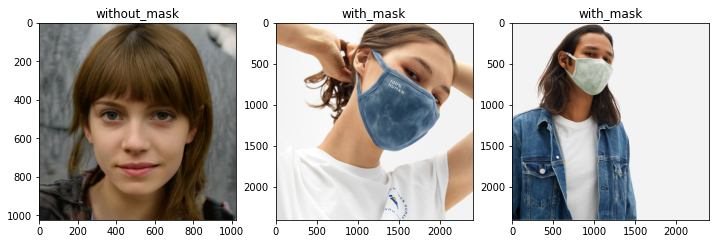

In [83]:
# cv2_imshow(image)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
label = classify_face(image)
ax1.set_title(label)
ax2.imshow(cv2.cvtColor(image_woman_with_mask1, cv2.COLOR_BGR2RGB))
label = classify_face(image_woman_with_mask1)
ax2.set_title(label)
ax3.imshow(cv2.cvtColor(image_woman_with_mask2, cv2.COLOR_BGR2RGB))
label = classify_face(image_woman_with_mask2)
ax3.set_title(label)
plt.show()